# Roboflow and DepthAI Tutorial: Train and Deploy a custom object detection model with depth! 

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)


<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

We highly recommend working through this notebook with the corresponding blog post in hand. 

A Major shoutout to Luxonis, the creators of the OAK-D Device for originally putting this tutorial together. Here, we streamline the training process with data management, transformation, and exportation from Roboflow. 

At the end of this tutorial, you will have a custom trained object detection model to deploy to your OAK-D device!


Insert GIF

The steps we take to train and deploy our custom model are as follows 


* Install MobileNet Training Environment Dependencies





# Install Training Environment Dependencies and Configs

In [ ]:
# %%capture
#After this cell executes runtime will restart to finish the install, ignore and close the crash message, continue running cells starting with the one below
!pip install numpy==1.17.5;
import os
os.kill(os.getpid(), 9)

     |████████████████████████████████| 20.0MB 1.3MB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.17.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [ ]:
%tensorflow_version 1.x
!pip install tf_slim

TensorFlow 1.x selected.
     |████████████████████████████████| 358kB 12.4MB/s 


In [ ]:

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.

num_steps = 5000  # A step means using a single batch of data. larger batch, less steps required
#60000 steps is required to train our example sign language dataset, less or more may be required based on your custom datasets needs

#Number of evaluation steps.
num_eval_steps = 50
#Batch size 24 is a setting that generally works well. can be changed higher or lower 
MODELS_CONFIG = {
        'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 24
    }
}
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colab's GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

# Install Tensorflow Object Detection API

Clone TF models which contains the Object Detection API; also install the required dependencies


In [ ]:
# %%capture
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git
%cd /content/models/
!git checkout 58d19c67e1d30d905dd5c6e5092348658fed80af
!apt-get update && apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py

/content
/content/models
Note: checking out '58d19c67e1d30d905dd5c6e5092348658fed80af'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 58d19c67 Internal change
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.

In [ ]:
import os

repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull


/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.83 MiB | 17.86 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Prepare `tfrecord` files



In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

!curl -L "[YOUR-LINK-HERE]" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/tensorflow-object-detection-faster-rcnn/data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1405      0 --:--:-- --:--:-- --:--:--  1405
100 22.2M  100 22.2M    0     0  12.8M      0  0:00:01  0:00:01 --:--:-- 24.8M
Archive:  roboflow.zip
 extracting: test/Letters.tfrecord   
 extracting: train/Letters.tfrecord  
 extracting: valid/Letters.tfrecord  
 extracting: test/Letters_label_map.pbtxt  
 extracting: train/Letters_label_map.pbtxt  
 extracting: valid/Letters_label_map.pbtxt  
 extracting: README.roboflow.txt     


In [ ]:
#RENAME Based on your annotation type - In this example our annotation type is "letters"
#RENAME to the file path based on your download above ^^
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/Letters.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/Letters.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/Letters_label_map.pbtxt'

In [ ]:
#double check that our class names came through
#Rename based on your data above^^
%cat '/content/tensorflow-object-detection-faster-rcnn/data/train/Letters_label_map.pbtxt'

item {
    name: "A",
    id: 1,
    display_name: "A"
}
item {
    name: "B",
    id: 2,
    display_name: "B"
}
item {
    name: "C",
    id: 3,
    display_name: "C"
}
item {
    name: "D",
    id: 4,
    display_name: "D"
}
item {
    name: "E",
    id: 5,
    display_name: "E"
}
item {
    name: "F",
    id: 6,
    display_name: "F"
}
item {
    name: "G",
    id: 7,
    display_name: "G"
}
item {
    name: "H",
    id: 8,
    display_name: "H"
}
item {
    name: "I",
    id: 9,
    display_name: "I"
}
item {
    name: "J",
    id: 10,
    display_name: "J"
}
item {
    name: "K",
    id: 11,
    display_name: "K"
}
item {
    name: "L",
    id: 12,
    display_name: "L"
}
item {
    name: "M",
    id: 13,
    display_name: "M"
}
item {
    name: "N",
    id: 14,
    display_name: "N"
}
item {
    name: "O",
    id: 15,
    display_name: "O"
}
item {
    name: "P",
    id: 16,
    display_name: "P"
}
item {
    name: "Q",
    id: 17,
    display_name: "Q"
}
item {
    name: "R",
 

In [ ]:
!ls '/content/tensorflow-object-detection-faster-rcnn/data/'

FYI.txt  README.roboflow.txt  test  train  valid


## Download the Mobilenet SSD v2 Model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research
/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 63 root   root  4.0K Mar 15 05:27 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [ ]:
#TF pretrained model checkpoint
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re
iou_threshold = 0.50
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    print(pipeline_fname)
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    # Set number of classes num_classes.
    s = re.sub('iou_threshold: [0-9].[0-9]+',
               'iou_threshold: {}'.format(iou_threshold), s)
    
    f.write(s)

/content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [ ]:
# #Have a look at the config file with various settings
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 26
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect

# Train Custom Mobilenet Model


In [ ]:
model_dir = 'training/'
# Optionally remove content in output model directory for a fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

#training will take a while (the TF OD library is not heavily optimized for speed on GPU), watch the mAP metrics rise, you can quit training early when you think your model has maxed out performance

W0315 05:27:45.418380 140150642440064 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 5000
I0315 05:27:45.418617 140150642440064 config_util.py:552] Maybe overwriting train_steps: 5000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0315 05:27:45.418723 140150642440064 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0315 05:27:45.418805 140150642440064 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0315 05:27:45.418887 140150642440064 config_util.py:552] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0315 05:27:45.418983 140150642440064 config_util.py:552] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0315 05:27:45.419080 140150642440064 config_util.py:5

In [ ]:
#model dir check for the trained model
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1615786083.890c419d93e9
export
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-2093.data-00000-of-00001
model.ckpt-2093.index
model.ckpt-2093.meta
model.ckpt-4201.data-00000-of-00001
model.ckpt-4201.index
model.ckpt-4201.meta
model.ckpt-5000.data-00000-of-00001
model.ckpt-5000.index
model.ckpt-5000.meta


## Export a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [ ]:
#clean output_directory if necessary to start fresh:

# !rm -rf /content/object_detection_demo/fine_tuned_model/ 
# os.makedirs('/content/object_detection_demo_flow/fine_tuned_model/', exist_ok=True)

In [ ]:
%%capture
import re
import numpy as np

output_directory = './fine_tuned_model'
# output_directory = '/content/gdrive/My\ Drive/data/'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

In [ ]:
#export directory check
# !ls {output_directory}

In [ ]:
import os
pb_fname = os.path.join(os.path.abspath(output_directory), "saved_model/saved_model.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)
# !ls -alh {pb_fname}

In [ ]:
#download frozen graph for posterity, you can keep this so you don't have to start over on training
from google.colab import files
files.download(pb_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Running Inference: Checking what the trained model can detect
Test with images in repository `tensorflow-object-detection-faster-rcnn/data/images/final test` directory.

In [ ]:
#You will need to import test images into the test folder specified below - In Roboflow you can export raw images in YOLO Darknet format

test_folder = '/content/tensorflow-object-detection-faster-rcnn'
sample_img = 'https://storage.googleapis.com/roboflow-platform-transforms/D7CAGZafFYZMvKbKibZGc42BUAx2/56694b0cb356d57b9da4914993042958/transformed.jpg'

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR = test_folder + "/data/test/"

import urllib.request
urllib.request.urlretrieve(sample_img, 
                           PATH_TO_TEST_IMAGES_DIR + "language.jpg")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/data/test/language.jpg']


/content/models/research/object_detection
/content/tensorflow-object-detection-faster-rcnn/data/test/language.jpg


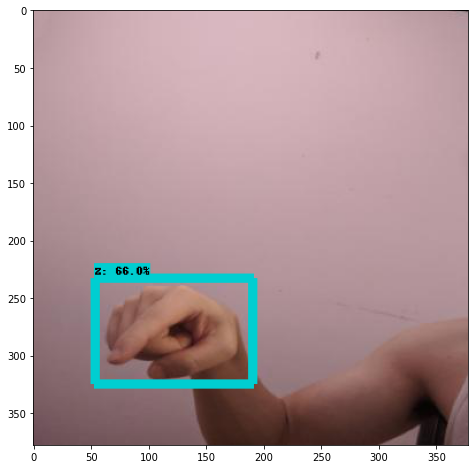

In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
# This is needed to display the images.
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    PATH_TO_CKPT = '/content/models/research/fine_tuned_model/frozen_inference_graph.pb'
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    print(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()

# Convert TF model to OpenVINO 20.01 Intermediate Representation (IR)
 This can be used to run inference on OpenVINO.
# In order to run the model on DepthAI modules, we then compile the IR obtained above to a .blob (via a server we set up just for that) 

## First, we install Open Vino 20.01


In [ ]:
%cd ../..

/content/models


In [ ]:
%%time
# %%capture
## install tools. Open Vino takes some time to download: 10-15 min sometimes.
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove
## downnload installation files
!wget http://registrationcenter-download.intel.com/akdlm/irc_nas/16345/l_openvino_toolkit_p_2020.1.023.tgz
path = "l_openvino_toolkit_p_2020.1.023.tgz"
# path = "/content/software/Intel OpenVINO 2019 R3.1/l_openvino_toolkit_p_2019.3.376.tgz"
## install openvino
!tar xf "{path}"
# !tar xf "{path}" && \
#     cd l_openvino_toolkit_p* && \
#     ./install_openvino_dependencies.sh && \
#     sed -i 's/decline/accept/g' silent.cfg && \
#     ./install.sh
# ## install dependencies
# !/opt/intel/openvino/install_dependencies/install_openvino_dependencies.sh
# ## install prerequisites
# !/opt/intel/openvino/deployment_tools/model_optimizer/install_prerequisites/install_prerequisites.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpci3
Suggested packages:
  libarchive1
The following NEW packages will be installed:
  cpio libpci3 pciutils
0 upgraded, 3 newly installed, 0 to remove and 48 not upgraded.
Need to get 368 kB of archives.
After this operation, 1,786 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 cpio amd64 2.12+dfsg-6ubuntu0.18.04.1 [86.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpci3 amd64 1:3.5.2-1ubuntu1.1 [24.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 pciutils amd64 1:3.5.2-1ubuntu1.1 [257 kB]
Fetched 368 kB in 0s (4,004 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> lin

In [ ]:
%%capture
%cd l_openvino_toolkit_p_2020.1.023/
!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

In [ ]:
!ls

EULA.txt	install_openvino_dependencies.sh  pset		  rpm
install_GUI.sh	install.sh			  PUBLIC_KEY.PUB  silent.cfg


[Optional] Open Vino install check, generally not needed

In [ ]:
!source /opt/intel/openvino/bin/setupvars.sh && \
    /opt/intel/openvino/deployment_tools/demo/demo_squeezenet_download_convert_run.sh

[setupvars.sh] OpenVINO environment initialized
target_precision = FP16
[setupvars.sh] OpenVINO environment initialized


###################################################



Installing dependencies
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:13

### Here we run some modifications in the ssd2 OpenVINO extension for TF so that our Mobilenet SSDv2 model can convert successfully to the IR

In [ ]:
%cd /opt/intel/openvino/deployment_tools/model_optimizer/extensions/front/tf/
#openvino fixes: edit 
# Read in the file, make sure the .json corresponds to the model!!!
with open('ssd_v2_support.json', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('"Postprocessor/ToFloat"', '"Postprocessor/Cast_1"')

# Write the file out again
with open('ssd_v2_support.json', 'w') as file:
  file.write(filedata)


/opt/intel/openvino_2020.1.023/deployment_tools/model_optimizer/extensions/front/tf


In [ ]:
%cp "/content/models/research/fine_tuned_model/saved_model/saved_model.pb" "/content/models/research/fine_tuned_model/"

## Convert TF model to Open Vino Intermediate Representation
If using own model, please change to your desired name for output directory --output_dir "choose name"

In [ ]:
#CONVERT TF MODEL to OPEN VINO IRv10. saved in IR_V10_fruits_mnssdv2_6k directory or
#choose own name for --output_dir "choose name"
%cd "/content/models/research/fine_tuned_model/"
!source /opt/intel/openvino/bin/setupvars.sh && \
    python /opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
    --input_model frozen_inference_graph.pb \
    --tensorflow_use_custom_operations_config /opt/intel/openvino/deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json \
    --tensorflow_object_detection_api_pipeline_config pipeline.config \
    --reverse_input_channels \
    --output_dir signs \
    --data_type FP16

/content/models/research/fine_tuned_model
[setupvars.sh] OpenVINO environment initialized
[ WARNING ]  Use of deprecated cli option --tensorflow_use_custom_operations_config detected. Option use in the following releases will be fatal. Please use --transformations_config cli option instead
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/models/research/fine_tuned_model/frozen_inference_graph.pb
	- Path for generated IR: 	/content/models/research/fine_tuned_model/signs
	- IR output name: 	frozen_inference_graph
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mea

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#check directory containing the exported TF trained model and the IRv10 folder
%ls 

checkpoint                      model.ckpt.index  saved_model/
frozen_inference_graph.pb       model.ckpt.meta   saved_model.pb
model.ckpt.data-00000-of-00001  pipeline.config   signs/


## Now we compile the IR model to a .blob for use on DepthAI modules/platform

---



### We save the blob in the IR directory from above, corresponding to --output_dir parameter above. 
The blob filename will be *frozen_inference_graph.blob*

In [ ]:
%ls /content/models/research/fine_tuned_model/signs

frozen_inference_graph.bin      frozen_inference_graph.xml
frozen_inference_graph.mapping


In [ ]:
#No changes needed here unless using custom data.
#CHOOSE the directory where you would like to save the blob.
# I use the same --output_dir as above for the IR conversion
blob_dir = "/content/models/research/fine_tuned_model/signs/"

#Copy the path of your .xml and .bin files. For that, you can look at the IR
#conversion output cell, select and copy from:
#[SUCCESS] XML file and bin file paths.
#Or you can choose to compile other .xml .bin files from a different location
#
xmlfile = "/content/models/research/fine_tuned_model/signs/frozen_inference_graph.xml"
binfile = "/content/models/research/fine_tuned_model/signs/frozen_inference_graph.bin"

import requests

#For openvino 20.01 use this link to compile the blob
url = "http://69.164.214.171:8080"


#open vino 20.02 link:
# url = "69.164.214.171:8081"

payload = {'compiler_params': '-ip U8 -VPU_MYRIAD_PLATFORM VPU_MYRIAD_2480 -VPU_NUMBER_OF_SHAVES 4 -VPU_NUMBER_OF_CMX_SLICES 4'}
files = [
  ('definition', open(xmlfile,'rb')),
  ('weights', open(binfile,'rb'))
]
# headers = {
#   'Content-Type': 'application/json'
# }
response = requests.request("POST", url, data = payload, files = files)
blobnameraw = response.headers.get('Content-Disposition')
print(blobnameraw)
blobname = blobnameraw[blobnameraw.find('='):][1:]
with open(blob_dir + blobname, 'wb') as f:
  f.write(response.content)

attachment; filename=frozen_inference_graph.blob


In [ ]:
from google.colab import files
files.download('/content/models/research/fine_tuned_model/signs/frozen_inference_graph.blob')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## To run the .blob in DepthAI, we proceed step 5 here:
 https://docs.luxonis.com/tutorials/object_det_mnssv2_training/